# Индивидуальное задание

## Кластерный анализ

Импорт библиотек

In [1]:
import numpy as np #работа с массивами
import pandas as pd #работа с таблицами

import matplotlib.pyplot as plt #графики
%matplotlib inline

from sklearn.cluster import KMeans #кластеризация
from sklearn.metrics import silhouette_score #силуэт

import re #регулярные выражения

from scipy.stats import t #t-распределение Стьюдента

Загружаем данные

In [6]:
data = pd.read_csv('2.csv', delimiter=';', decimal='#', index_col='country')
data.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf1 in position 0: invalid continuation byte

Данные содержат пробелы в числах в столбце `income`, отформатируем их регулярными выражениями

In [ ]:
for i in data.index:
    data.loc[i, 'income'] = np.float64(re.sub(' ', '', data.loc[i, 'income']))

Для анализа предлагается отбросить столбец `region`

In [ ]:
data = data.drop(columns=['region'])
data.head()

Составляем матрицу признаков

In [3]:
X = data.values

NameError: name 'data' is not defined

Нормируем данные методом масштабирования

In [6]:
X -= X.min(axis=0)
X /= X.max(axis=0) - X.min(axis=0)

Проводим кластерный анализ методом `k-means`. Для каждого варианта разбиения (от двух до десяти кластеров) рассчитаем силуэт

In [7]:
for i in range(2, 11):
    model = KMeans(n_clusters=i, random_state=42).fit(X)
    print('Silhouette score for {} clusters:\t{:.2f}'.format(i, float(silhouette_score(X, model.labels_))))

Silhouette score for 2 clusters:	0.49
Silhouette score for 3 clusters:	0.44
Silhouette score for 4 clusters:	0.44
Silhouette score for 5 clusters:	0.43
Silhouette score for 6 clusters:	0.41
Silhouette score for 7 clusters:	0.36
Silhouette score for 8 clusters:	0.38
Silhouette score for 9 clusters:	0.34
Silhouette score for 10 clusters:	0.36


Как видим, лучшее значение силуэта получено при двух кластерах. На этом варианте и остановимся

In [8]:
model = KMeans(n_clusters=2, random_state=42).fit(X)

Добавим результаты кластеризации в данные

In [9]:
data['cluster'] = model.labels_
data.head()

,fertility,mortality,child_mortality,men_expectancy,women_expectancy,income,cluster
country,,,,,,,
Albania,24.7,5.7,30.8,69.6,75.5,600,0
Bulgaria,12.5,11.9,14.4,68.3,74.7,2250,0
Czechoslovakia,13.4,11.7,11.3,71.8,77.7,2980,0
Former_E_Germany,12.0,12.4,7.6,69.8,75.9,3000,0
Hungary,11.6,13.4,14.8,65.4,73.8,2780,0


Посмотрим на средние значения в кластерах

## Визуализация

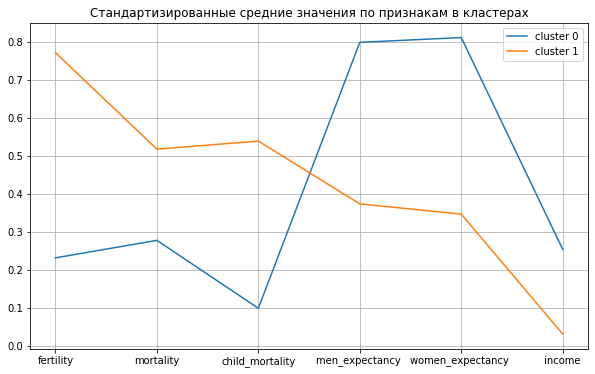

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(data.columns[np.arange(6)], X[data['cluster'] == 0].mean(axis=0), label='cluster 0')
plt.plot(data.columns[np.arange(6)], X[data['cluster'] == 1].mean(axis=0), label='cluster 1')
plt.title('Стандартизированные средние значения по признакам в кластерах')
plt.legend()
plt.grid()
plt.show()

## Проверка значимости различая средних

Поскольку у нас всего два кластера, то можно сравнить, значимо ли различие средних значений в выборках по критерию Стьюдента. Нулевая гипотеза: различие незначимо

$$\frac{|\bar{x_1} - \bar{x_2}|}{\sqrt{\frac{D_1}{n_1} + \frac{D_2}{n_2}}}$$

In [11]:
bar_x_0 = X[data['cluster'] == 0].mean(axis=0) #среднее значение в кластере 0
bar_x_1 = X[data['cluster'] == 1].mean(axis=0) #среднее значение в кластере 1
D_0 = X[data['cluster'] == 0].var(axis=0) #дисперсия в кластере 0
D_1 = X[data['cluster'] == 1].var(axis=0) #дисперсия в кластере 1
n_0 = X[data['cluster'] == 0].shape[0] #количество элементов в кластере 0
n_1 = X[data['cluster'] == 1].shape[0] #количество элементов в кластере 1

student = np.abs(bar_x_0 - bar_x_1)/np.sqrt(np.array(D_0/n_0 + D_1/n_1, dtype='float64')) #t-статистика Стьюдента
p_value = 1 - t.cdf(10, np.array(student, dtype='float64')) #P-value

print('Расчёт для столбца fertility:        P-value = {:.6f}'.format(float(p_value[0])))
print('Расчёт для столбца mortality:        P-value = {:.6f}'.format(float(p_value[1])))
print('Расчёт для столбца child_mortality:  P-value = {:.6f}'.format(float(p_value[2])))
print('Расчёт для столбца men_expectancy:   P-value = {:.6f}'.format(float(p_value[3])))
print('Расчёт для столбца women_expectancy: P-value = {:.6f}'.format(float(p_value[4])))
print('Расчёт для столбца income:           P-value = {:.6f}'.format(float(p_value[5])))

Расчёт для столбца fertility:        P-value = 0.000000
Расчёт для столбца mortality:        P-value = 0.000017
Расчёт для столбца child_mortality:  P-value = 0.000000
Расчёт для столбца men_expectancy:   P-value = 0.000000
Расчёт для столбца women_expectancy: P-value = 0.000000
Расчёт для столбца income:           P-value = 0.000024


Все различия значимы. Кластеризация по каждому столбцу осмысленна. 

## Интерпретация кластеров

Кластер 0 содержит страны с низкой рождаемостью, низкой смертностью, низкой смертностью среди детей, высокой средней продолжительностью жизни как у мужчин, так и у женщин и высоким доходом. Показатели кластера 1 прямо противоположные. Можно сделать вывод о том, что в кластер 0 попали развитые страные, а в кластер 1 – развивающиеся. 